# Demonstrate differences when using Tensorflow on different CPU types

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import random as rn
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Dense, Softmax

pd.set_option("display.float_format", '{:.6f}'.format)

2021-12-09 21:58:16.669337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-09 21:58:16.669378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def getCPUtype():
    cpuinfo = subprocess.check_output("cat /proc/cpuinfo", shell=True).decode()
    for l in cpuinfo.split("\n"):
        if l.find("vendor_id") >= 0:
            if l.find("GenuineIntel") >= 0:
                return "Intel"
            else:
                return "AMD"

def gen_iterator_rand(mini_batch_size, dataset, labels):
    while True:
        rand_idx = np.random.choice(range(dataset.shape[0]), mini_batch_size, False)
        yield dataset[rand_idx, :], labels[rand_idx].astype('int32')

## Load data

In [3]:
CPUtype = getCPUtype()
TFVersion = tf.__version__
print("CPU type:", CPUtype, "Tensorflow:", TFVersion)

train_df = pd.read_csv("training_data.csv", index_col=0)
val_df = pd.read_csv("validation_data.csv", index_col=0)
print("Data shapes:", train_df.shape, val_df.shape)
display(train_df.head())

CPU type: Intel Tensorflow: 2.5.0
Data shapes: (902, 30) (221, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,truth
0,0.638492,0.742388,-0.786132,-0.065854,2.026080,1.199561,-1.478876,2.080921,-0.082029,1.192170,...,0.958104,-1.072159,0.665050,-0.817841,-0.081059,1.772153,0.304970,0.079072,0.054353,1
1,-0.327518,2.126654,-1.202952,0.364890,1.047391,3.235585,-0.726095,0.735434,-0.609795,2.563223,...,-0.100828,-1.703420,0.092144,-0.829313,-1.353283,1.775399,0.951535,-1.172072,0.455788,1
2,1.887291,1.354943,-0.314060,-0.624617,0.094917,1.002899,-0.455322,-0.376964,0.914075,1.550020,...,0.323688,1.183806,0.239659,0.871356,0.815638,0.725866,0.416811,-0.626805,0.083920,1
3,1.263448,0.843022,-1.821396,-0.817398,1.037859,2.108119,-1.858121,1.078692,0.433002,2.411664,...,-0.932172,-1.180098,0.973801,-1.627008,-0.339502,1.055874,0.378411,-2.054756,-0.391434,1
4,-1.443829,1.429872,-1.135098,-0.930356,-0.438913,1.631148,-1.345121,0.004546,0.125964,-0.786524,...,1.265878,-1.894231,0.493521,-1.420498,0.028886,1.749431,1.279378,-0.972321,1.052824,0


## Make model 

In [4]:
tf_seed = 371
batch_size = 128
iteration = 50
hidden_layers = 3
learning_rate = 0.1
hidden_units = 20

# set the various random seeds
np.random.seed(888)
rn.seed(12345)

tf.random.set_seed(tf_seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

initialization = tf.keras.initializers.GlorotUniform(seed=2)

dense_input = tf.keras.Input(shape=(29,), dtype=tf.float32)

a = Dense(
    units=hidden_units,
    activation="relu",
    kernel_initializer=initialization
)(dense_input)

count = 1
for i in range(hidden_layers - 1):
    a = Dense(
        units=hidden_units,
        activation="relu",
        kernel_initializer=initialization
    )(a)
    a = BatchNormalization()(a)

# final layer 
predictions = Dense(
    units=2,
    activation="softmax",
    kernel_initializer=initialization
)(a)

model = Model(inputs=dense_input, outputs=predictions)

adam_opt = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    name="Adam"
)
model.compile(optimizer=adam_opt, loss='sparse_categorical_crossentropy', run_eagerly=False)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42    

2021-12-09 21:58:17.807117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-09 21:58:17.807156: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-09 21:58:17.807180: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-8-178): /proc/driver/nvidia/version does not exist
2021-12-09 21:58:17.807416: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Fit model

In [5]:
start_iter=0
np.random.seed(tf_seed)
logfile = open(f"batches_{CPUtype}.log","w")
gen_batch = gen_iterator_rand(batch_size,train_df.drop(["truth"], axis=1).values, 
                                   labels=train_df["truth"].values)
for i in range(start_iter, iteration):
    batch_x, batch_y = next(gen_batch)
    for i,b in enumerate(batch_x):
        logfile.write(repr(i) +" "+ repr(b) +"\n")
    logfile.write("\n")
    #print(batch_x.shape, batch_y.shape)
    model.train_on_batch(batch_x, batch_y)
logfile.close()
val_df["prob_1"] = model.predict(val_df.drop(["truth"], axis=1).values)[:,1]
#display(val_df)
val_df.to_csv(f"val_preds_{CPUtype}_TF{TFVersion}.csv")

2021-12-09 21:58:18.440027: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-09 21:58:18.442638: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2500000000 Hz


In [6]:
! diff -s batches_AMD.log batches_Intel.log 

diff: batches_AMD.log: No such file or directory


### Plot Intel vs. AMD

104   0.116367
13    0.106993
137   0.102547
11    0.078381
90    0.055102
83    0.051458
88    0.048147
148   0.046665
110   0.044283
185   0.039673
Name: prob_1, dtype: float64


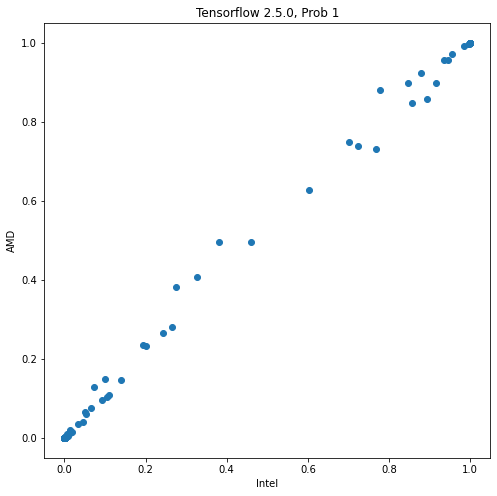

In [7]:
AMDfile = f"val_preds_AMD_TF{TFVersion}.csv"
IntelFile = f"val_preds_Intel_TF{TFVersion}.csv"
if os.path.exists(AMDfile) and os.path.exists(IntelFile):
    amd = pd.read_csv(AMDfile)
    intel = pd.read_csv(IntelFile)
    print((intel["prob_1"] - amd["prob_1"]).abs().sort_values(ascending=False).head(10))
    fg = plt.figure(figsize=(8,8))
    plt.scatter(intel["prob_1"], amd["prob_1"])
    plt.title(f"Tensorflow {TFVersion}, Prob 1")
    plt.xlabel("Intel")
    plt.ylabel("AMD")
    plt.show()